# Intro
The Hand Gesture Recognition Database is a collection of near-infra-red images of ten distinct hand gestures. In this notebook we use end-to-end deep learning to build a classifier for these images.

We'll first load some packages required for reading in and plotting the images. 

In [1]:
import numpy as np  # NumPy library for numerical computations
import os  # os module for interacting with the operating system
from PIL import Image  # Image class from PIL library for image processing

import matplotlib.pyplot as plt  # matplotlib library for visualization
import matplotlib.image as mpimg  # mpimg module for image loading/displaying
import keras  # Keras deep learning library

from keras.utils import to_categorical  # to_categorical function from Keras utils for one-hot encoding
from random import randint  # randint function from random module for generating random integers
import cv2  # OpenCV library for computer vision tasks

from sklearn.model_selection import train_test_split  # train_test_split function from sklearn for data splitting
from keras import layers  # layers module from Keras for building neural network layers
from keras import models  # models module from Keras for defining neural network models

2024-04-07 13:27:10.308856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 13:27:10.309006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 13:27:10.447022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


As described in the Data Overview, there are 10 folders labelled 00 to 09, each containing images from a given subject. In each folder there are subfolders for each gesture. We'll build a dictionary `lookup` storing the names of the gestures we need to identify, and giving each gesture a numerical identifier. We'll also build a dictionary `reverselookup` that tells us what gesture is associated to a given identifier.

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'02_l': 0,
 '04_fist_moved': 1,
 '09_c': 2,
 '10_down': 3,
 '06_index': 4,
 '08_palm_moved': 5,
 '07_ok': 6,
 '05_thumb': 7,
 '01_palm': 8,
 '03_fist': 9}

Next we read in the images, storing them in `x_data`. We store the numerical classifier for each image in `y_data`. Since the images are quite large and are coming from an infra-red sensor, there's nothing really lost in converting them to greyscale and resizing to speed up the computations.

In [3]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('../input/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)

In [4]:
y_data.shape[0]

100

In [5]:
y_data.shape[1]

200

In [6]:
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

In [7]:
y_data.shape[0]

20000

In [8]:
y_data.shape[1]

1

Let's take a look at some of the pictures. Since each of the subfolders in `00` contained 200 images, we'll use the following piece of code to load one image of each gesture.

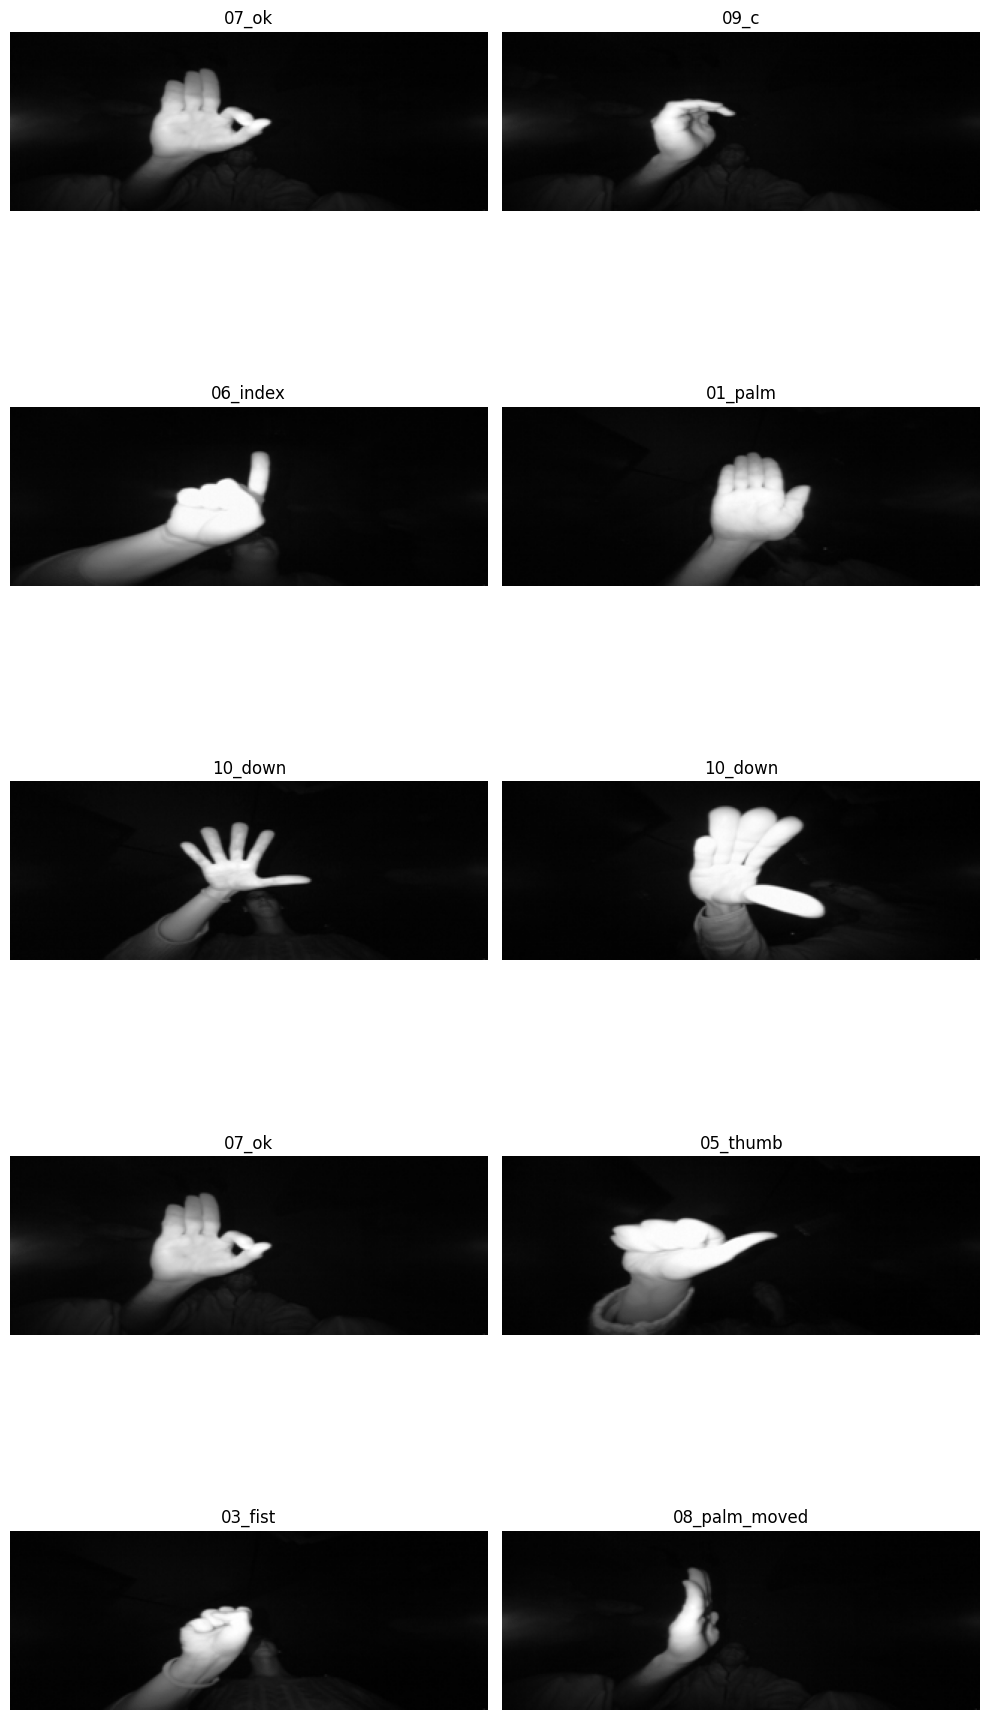

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

# Iterate through each pair of images
for i, ax_row in enumerate(axes):
    # Get two random indices within the range of data
    random_index1 = randint(0, len(x_data) - 1)
    random_index2 = randint(0, len(x_data) - 1)
    
    # Display the first image
    ax_row[0].imshow(x_data[random_index1], cmap='gray')
    ax_row[0].set_title(reverselookup[y_data[random_index1, 0]])
    ax_row[0].axis('off')

    # Display the second image
    ax_row[1].imshow(x_data[random_index2], cmap='gray')
    ax_row[1].set_title(reverselookup[y_data[random_index2, 0]])
    ax_row[1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()


The first thing to note is that this is not a difficult classification problem. The gestures are quite distinct, the images are clear, and there's no background whatsoever to worry about. If you weren't comfortable with deep learning, you could do quite well with some straight-forward feature detection -- for example the '07_ok' class could easily be detected with binary thresholding followed by circle detection. 

Moreover, the gestures consistently occupy only about 25% of the image, and all would fit snugly inside a square bounding box. Again if you're looking to do basic feature detection, an easy first step would be to write a short script cropping everything to the relevant 120 x 120 square. 

But the point of this notebook is to show how effective it is to just throw a neural network at a problem like this without having to worry about any of the above, so that's what we're going to do. 

At the moment our vector `y_data` has shape `(datacount, 1)`, with `y_data[i,0] = j` if the `i`th image in our dataset is of gesture `reverselookup[j]`. In order to convert it to one-hot format, we use the keras function to_categorical:

In [10]:
y_data = to_categorical(y_data)

Our set of images has shape `(datacount, 120, 320)`. Keras will be expecting another slot to tell it the number of channels, so we reshape `x_data` accordingly. We also rescale the values in `x_data` to lie between 0 and 1.

In [11]:
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

We need a cross-validation set and a test set, and we'll use the `sklearn` package to construct these. In order to get an 80-10-10 split, we call `train_test_split` twice, first to split 80-20, then to split the smaller chunk 50-50. Note that we do this after the rescaling step above, to ensure that our train and test sets are coming from the same distribution.

In [12]:
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

Now it's time to build our network. We'll use keras.

Since our images are big (we chose not to do any cropping) and the classification problem looks quite easy, we're going to downsample fairly aggressively, beginning with a 5 x 5 filter with a stride of 2. Note we have to specify the correct input shape at this initial layer, and keras will figure it out from then on. We won't worry about padding since it's clear that all the useful features are well inside the image. We'll continue with a sequence of convolutional layers followed by max-pooling until we arrive at a small enough image that we can add a fully-connected layer. Since we need to classify between 10 possibilities, we finish with a softmax layer with 10 neurons. 

In [13]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
model

<Sequential name=sequential, built=True>

Finally, we fit the model.

In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

Epoch 1/10
 15/250 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1570 - loss: 2.2414

I0000 00:00:1712496637.818444      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7022 - loss: 0.8893 - val_accuracy: 0.9995 - val_loss: 0.0037
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9955 - loss: 0.0197 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9860 - val_loss: 0.0346
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 3.8290e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9999 - loss: 2.6998e-04 - val_accuracy: 1.0000 - val_loss: 1.2458e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 3.6297e-05 - val_accuracy: 1.0000 - val_loss: 1.9570e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 3.0655e-06 - val_accuracy: 1.0000 - val_loss: 2.0799e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss:

At this point we would typically graph the accuracy of our model on the validation set, and choose a suitable number of epochs to train for to avoid overfitting. We might also consider introducing dropout and regularisation. However, we can see we're getting perfect accuracy on the validation set after just one or two epochs, so we're pretty much done. Let's quickly confirm that this is carrying through to the test set:

In [16]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0089
Accuracy:0.9994999766349792


You'll get slightly different numbers each time you run it but you should be getting between 99.9 and 100% accuracy. Great!

In [19]:
model.save('hand_gesture_model.h5')

In [17]:

image = Image.open('/kaggle/input/handges/palm.jpeg')

# Convert to grayscale
image_gray = image.convert('L')

# Resize the image
image_resized = image_gray.resize((320, 120))

# Convert image to numpy array
image_array = np.array(image_resized)

# Reshape array if necessary (e.g., for single image)
image_array = image_array.reshape((1, 120, 320, 1))

# Normalize pixel values
image_array = image_array.astype('float32') / 255.0


In [20]:

# Make predictions using the model
predictions = model.predict(image_array)

# Get the index of the gesture with the highest probability
predicted_index = np.argmax(predictions)

# Map the predicted index to the corresponding gesture
#label using the reverse lookup dictionary
predicted_gesture = reverselookup[predicted_index]

# Print the predicted gesture
print("Predicted Gesture:", predicted_gesture)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
Predicted Gesture: 03_fist


In [21]:
video_capture = cv2.VideoCapture('/kaggle/input/testing-handges-video/Testing_handGes_video.mp4')

video_capture

< cv2.VideoCapture 0x79f5cc2f29b0>

In [23]:
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

frames = []

frame_rate = int(video_capture.get(cv2.CAP_PROP_FPS))

# Calculate frame interval
frame_interval = frame_rate * 3 

# Read frames at specified intervals
for i in range(0, total_frames, frame_interval):
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = video_capture.read()
    if success:
        frames.append(frame)

# Release the video capture object
video_capture.release()

# Convert the list of frames to a NumPy array
frames_array = np.array(frames)

# Print the shape of the frames array
print("Shape of frames array:", frames_array.shape)


Shape of frames array: (5, 480, 480, 3)


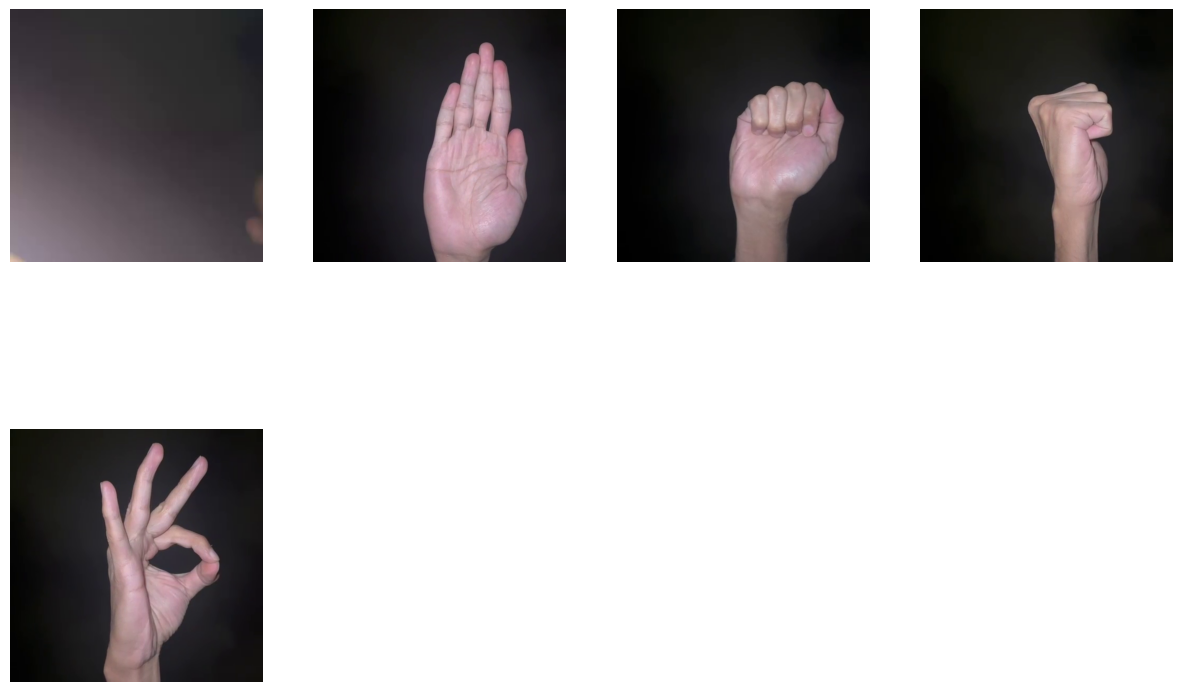

In [24]:

def display_images(images, cols=4):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Display the images
display_images(frames)


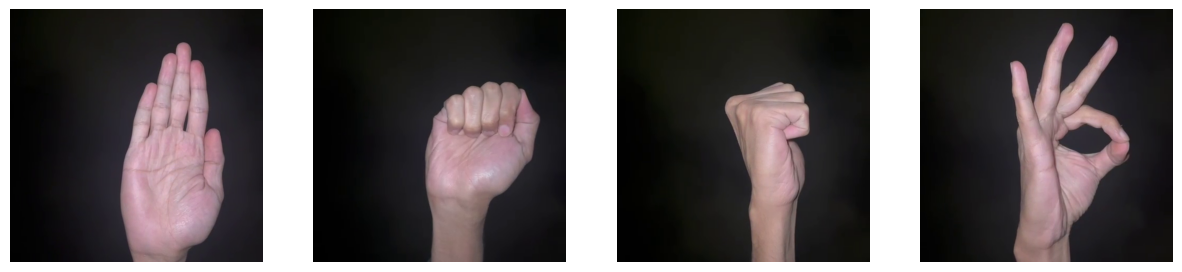

In [25]:
# Drop the first frame from the frames list
frames_to_display = frames[1:]

# Display the images
display_images(frames_to_display)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


W0000 00:00:1712497300.917345      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


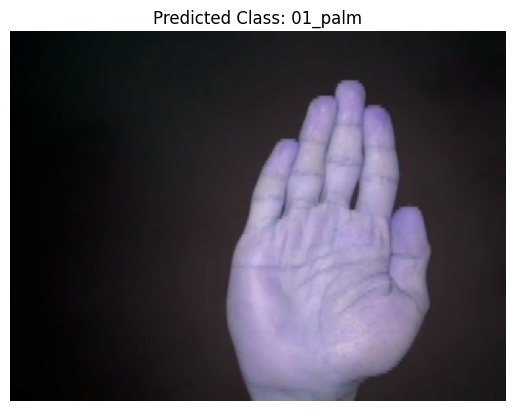

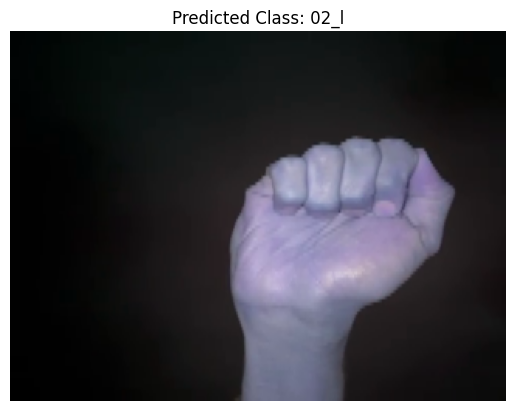

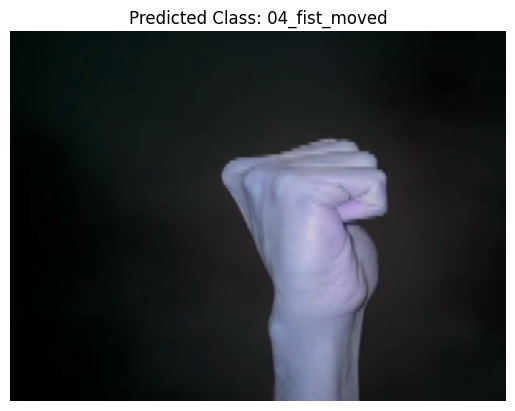

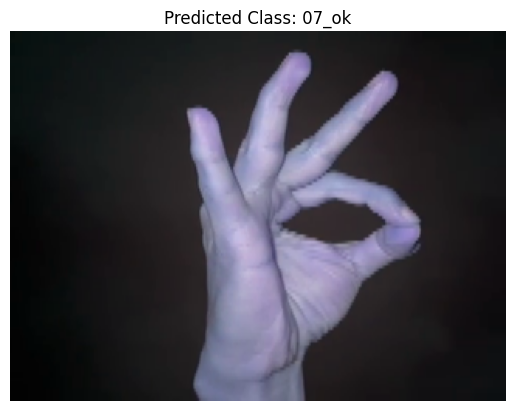

In [26]:
# Resize input images to match the size the model was trained on (120x320)
resized_frames = [cv2.resize(frame, (320, 120)) for frame in frames_to_display]

# Convert images to grayscale
gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in resized_frames]

# Convert images to numpy arrays
image_arrays = np.array(gray_frames)

# Reshape arrays if necessary (e.g., for single image)
image_arrays = image_arrays.reshape((-1, 120, 320, 1))

# Normalize pixel values
image_arrays = image_arrays.astype('float32') / 255.0
# Predict the classes of the resized images
# Predict the classes of the resized images
probabilities = model.predict(image_arrays)

# Convert probabilities to class labels using the provided label mapping
predicted_classes = np.argmax(probabilities, axis=1)
class_labels = [reverselookup[predicted_class] for predicted_class in predicted_classes]

# Display the predicted classes along with the corresponding resized images
for i, predicted_class in enumerate(predicted_classes):
    plt.figure()
    plt.imshow(resized_frames[i], aspect='auto', cmap='gray')  # Use aspect='auto' and cmap='gray'
    plt.title(f'Predicted Class: {class_labels[i]}')
    plt.axis('off')
    plt.show()

